Train images shape: (60000, 784)
Train labels shape: (60000,)
X_train shape: (784, 48000)
Y_train shape: (48000,)

Starting training...

Iteration 0, Accuracy: 0.155
Iteration 20, Accuracy: 0.299
Iteration 40, Accuracy: 0.411
Iteration 60, Accuracy: 0.508
Iteration 80, Accuracy: 0.580
Iteration 100, Accuracy: 0.635
Iteration 120, Accuracy: 0.674
Iteration 140, Accuracy: 0.701
Iteration 160, Accuracy: 0.722
Iteration 180, Accuracy: 0.739
Validation Accuracy = 0.753


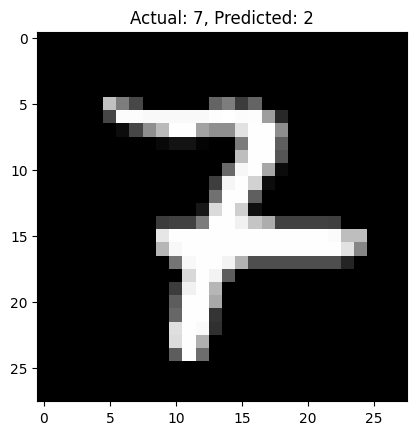

In [5]:
import numpy as np
import matplotlib.pyplot as plt

####################
# 1) Load MNIST Data
####################

def load_images(filename):
    with open(filename, 'rb') as f:
        data = f.read()
    # Each image is 28x28 => 784 pixels
    # Skip first 16 bytes (magic number, dims)
    images = np.frombuffer(data, dtype=np.uint8, offset=16).reshape(-1, 28*28) / 255.0
    return images

def load_labels(filename):
    with open(filename, 'rb') as f:
        data = f.read()
    # Skip first 8 bytes (magic number, number of items)
    labels = np.frombuffer(data, dtype=np.uint8, offset=8)
    return labels

# Filenames (assumes these files are in the same folder as this notebook)
train_images_filename = "train-images-idx3-ubyte"
train_labels_filename = "train-labels-idx1-ubyte"

# Load
train_images = load_images(train_images_filename)
train_labels = load_labels(train_labels_filename)

print("Train images shape:", train_images.shape)  # (60000, 784) typically
print("Train labels shape:", train_labels.shape)   # (60000,)

#########################
# 2) Combine & Shuffle
#########################
# We put 'label' as the first column, then all pixels afterwards
data = np.column_stack((train_labels, train_images))  # shape => (num_samples, 1+784)
np.random.shuffle(data)

###########################
# 3) Train/Validation Split
###########################
m = data.shape[0]                # number of total samples
train_size = int(0.8 * m)        # 80% train, 20% validation
train_data = data[:train_size, :] 
val_data   = data[train_size:, :]

####################
# 4) X, Y separation
####################
# For training
X_train = train_data[:, 1:]  # all columns except the first => pixel data
Y_train = train_data[:, 0]   # the first column => label

# For validation
X_val = val_data[:, 1:]
Y_val = val_data[:, 0]

#########################
# 5) Ensure integer labels
#########################
Y_train = Y_train.astype(int)
Y_val   = Y_val.astype(int)

#############################
# 6) Transpose X (features, samples)
#############################
X_train = X_train.T  # shape => (784, number_of_samples)
X_val   = X_val.T    # shape => (784, number_of_samples)

print("X_train shape:", X_train.shape)  # (784, ?)
print("Y_train shape:", Y_train.shape)  # (?)

###################################################
# 7) Define Our Neural Network & Training Functions
###################################################

def initialize_parameters():
    # Let’s do 10 hidden neurons => shape (10, 784) for W1
    # and 10 output neurons => shape (10, 10) for W2
    # Bias shapes: (10,1)
    W1 = np.random.rand(10, 784) - 0.5
    B1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    B2 = np.random.rand(10, 1) - 0.5
    return W1, B1, W2, B2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax_calculator(Z):
    # Z => shape (10, m) if 10 classes
    # subtract max per column for numerical stability
    Z_stable = Z - np.max(Z, axis=0, keepdims=True)
    exps = np.exp(Z_stable)
    return exps / np.sum(exps, axis=0, keepdims=True)

def forward_propagation(W1, B1, W2, B2, X):
    # X => shape (784, m)
    Z1 = W1.dot(X) + B1    # shape => (10, m)
    A1 = ReLU(Z1)          # shape => (10, m)
    Z2 = W2.dot(A1) + B2   # shape => (10, m)
    A2 = softmax_calculator(Z2)  # shape => (10, m)
    return Z1, A1, Z2, A2

def one_hot_converter(Y):
    # Y => array of shape (m,) with integer labels in [0..9]
    # we want one_hot => shape (10, m)
    m = Y.size
    num_classes = Y.max() + 1  # typically 10 for MNIST
    one_hot = np.zeros((num_classes, m))
    one_hot[Y, np.arange(m)] = 1
    return one_hot

def backward_propagation(W1, B1, W2, B2, Z1, A1, Z2, A2, X, Y):
    # X => shape (784, m)
    # A2 => shape (10, m)
    m = X.shape[1]  # number_of_samples
    one_hot_Y = one_hot_converter(Y)  # shape => (10, m)

    dZ2 = A2 - one_hot_Y               # shape => (10, m)
    dW2 = (1/m) * dZ2.dot(A1.T)        # shape => (10, 10)
    dB2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)  # shape => (10, 1)

    dZ1 = W2.T.dot(dZ2) * (Z1 > 0)     # shape => (10, m)
    dW1 = (1/m) * dZ1.dot(X.T)         # shape => (10, 784)
    dB1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)  # shape => (10, 1)

    return dW1, dB1, dW2, dB2

def update_parameters(W1, B1, W2, B2, dW1, dB1, dW2, dB2, alpha):
    W1 -= alpha * dW1
    B1 -= alpha * dB1
    W2 -= alpha * dW2
    B2 -= alpha * dB2
    return W1, B1, W2, B2

def get_predictions(A2):
    # A2 => shape (10, m)
    # we want the index of the max along axis=0
    return np.argmax(A2, axis=0)

def get_accuracy(predictions, Y):
    return np.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    W1, B1, W2, B2 = initialize_parameters()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propagation(W1, B1, W2, B2, X)
        dW1, dB1, dW2, dB2 = backward_propagation(W1, B1, W2, B2, Z1, A1, Z2, A2, X, Y)
        W1, B1, W2, B2 = update_parameters(W1, B1, W2, B2, dW1, dB1, dW2, dB2, alpha)
        
        if i % 20 == 0:
            preds = get_predictions(A2)
            acc = get_accuracy(preds, Y)
            print(f"Iteration {i}, Accuracy: {acc:.3f}")
    return W1, B1, W2, B2

#################################
# 8) Train the Model
#################################
alpha = 0.1         # learning rate
iterations = 200    # or 1000, etc.

print("\nStarting training...\n")
W1, B1, W2, B2 = gradient_descent(X_train, Y_train, alpha, iterations)

#########################
# 9) Evaluate on Val Set
#########################
_, _, _, A2_val = forward_propagation(W1, B1, W2, B2, X_val)
preds_val = get_predictions(A2_val)
val_accuracy = get_accuracy(preds_val, Y_val)
print(f"Validation Accuracy = {val_accuracy:.3f}")

###########################
# 10) Inspect a Sample (Optional)
###########################
val_index = 100
sample_image = X_val[:, val_index].reshape(28, 28)
sample_label = Y_val[val_index]

# Make a single forward pass on that sample
_, _, _, A2_sample = forward_propagation(W1, B1, W2, B2, X_val[:, val_index, None])
predicted_label = get_predictions(A2_sample)[0]

plt.imshow(sample_image, cmap='gray')
plt.title(f"Actual: {sample_label}, Predicted: {predicted_label}")
plt.show()



Starting training with He initialization and 400 epochs...

Epoch 0, Training Accuracy: 0.1387
Epoch 20, Training Accuracy: 0.1776
Epoch 40, Training Accuracy: 0.2152
Epoch 60, Training Accuracy: 0.2453
Epoch 80, Training Accuracy: 0.2742
Epoch 100, Training Accuracy: 0.3028
Epoch 120, Training Accuracy: 0.3281
Epoch 140, Training Accuracy: 0.3505
Epoch 160, Training Accuracy: 0.3701
Epoch 180, Training Accuracy: 0.3852
Epoch 200, Training Accuracy: 0.3975
Epoch 220, Training Accuracy: 0.4053
Epoch 240, Training Accuracy: 0.4093
Epoch 260, Training Accuracy: 0.4198
Epoch 280, Training Accuracy: 0.4368
Epoch 300, Training Accuracy: 0.4632
Epoch 320, Training Accuracy: 0.5042
Epoch 340, Training Accuracy: 0.5362
Epoch 360, Training Accuracy: 0.5608
Epoch 380, Training Accuracy: 0.5825

Validation Accuracy = 0.6046


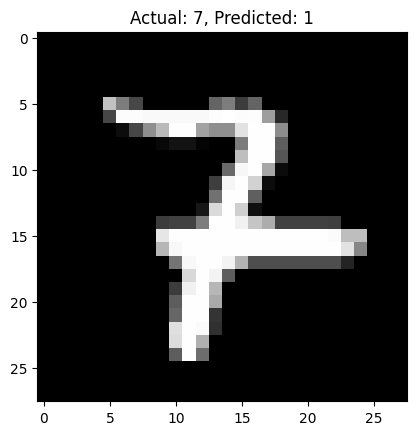

In [6]:
import numpy as np
import matplotlib.pyplot as plt

##############################
# 1. He Initialization
##############################
def initialize_parameters():
    """
    Initialize parameters using He initialization for a single hidden layer.
    - W1: (10, 784), B1: (10, 1)  -> Hidden layer
    - W2: (10, 10), B2: (10, 1)  -> Output layer
    """
    np.random.seed(0)  # For reproducibility
    W1 = np.random.randn(10, 784) * np.sqrt(2 / 784)
    B1 = np.zeros((10, 1))
    W2 = np.random.randn(10, 10) * np.sqrt(2 / 10)
    B2 = np.zeros((10, 1))
    return W1, B1, W2, B2

##############################
# 2. Activation Functions
##############################
def ReLU(Z):
    return np.maximum(0, Z)

def softmax_calculator(Z):
    Z_stable = Z - np.max(Z, axis=0, keepdims=True)  # Numerical stability
    exps = np.exp(Z_stable)
    return exps / np.sum(exps, axis=0, keepdims=True)

##############################
# 3. Forward Propagation
##############################
def forward_propagation(W1, B1, W2, B2, X):
    """
    Forward propagation for a single hidden layer.
    """
    Z1 = np.dot(W1, X) + B1  # Linear activation for hidden layer
    A1 = ReLU(Z1)            # ReLU activation for hidden layer
    Z2 = np.dot(W2, A1) + B2  # Linear activation for output layer
    A2 = softmax_calculator(Z2)  # Softmax activation for output layer
    return Z1, A1, Z2, A2

##############################
# 4. Backward Propagation
##############################
def one_hot_converter(Y):
    """
    Convert labels to one-hot encoding.
    """
    m = Y.size
    num_classes = Y.max() + 1
    one_hot = np.zeros((num_classes, m))
    one_hot[Y, np.arange(m)] = 1
    return one_hot

def backward_propagation(W1, B1, W2, B2, Z1, A1, Z2, A2, X, Y):
    """
    Backward propagation for a single hidden layer.
    """
    m = X.shape[1]
    one_hot_Y = one_hot_converter(Y)  # Convert labels to one-hot encoding

    # Gradients for output layer
    dZ2 = A2 - one_hot_Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    dB2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # Gradients for hidden layer
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0)  # Derivative of ReLU
    dW1 = (1/m) * np.dot(dZ1, X.T)
    dB1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, dB1, dW2, dB2

##############################
# 5. Update Parameters
##############################
def update_parameters(W1, B1, W2, B2, dW1, dB1, dW2, dB2, alpha):
    """
    Update weights and biases using gradient descent.
    """
    W1 -= alpha * dW1
    B1 -= alpha * dB1
    W2 -= alpha * dW2
    B2 -= alpha * dB2
    return W1, B1, W2, B2

##############################
# 6. Training Function
##############################
def get_predictions(A2):
    return np.argmax(A2, axis=0)

def get_accuracy(predictions, Y):
    return np.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    """
    Perform gradient descent for a single-hidden-layer network.
    """
    W1, B1, W2, B2 = initialize_parameters()
    for i in range(iterations):
        # Forward propagation
        Z1, A1, Z2, A2 = forward_propagation(W1, B1, W2, B2, X)
        # Backward propagation
        dW1, dB1, dW2, dB2 = backward_propagation(W1, B1, W2, B2, Z1, A1, Z2, A2, X, Y)
        # Update parameters
        W1, B1, W2, B2 = update_parameters(W1, B1, W2, B2, dW1, dB1, dW2, dB2, alpha)
        
        # Print training accuracy every 20 epochs
        if i % 20 == 0:
            preds = get_predictions(A2)
            acc = get_accuracy(preds, Y)
            print(f"Epoch {i}, Training Accuracy: {acc:.4f}")
    return W1, B1, W2, B2

##############################
# 7. Train and Evaluate
##############################
# Hyperparameters
alpha = 0.01       # Learning rate
iterations = 400   # Number of epochs

print("\nStarting training with He initialization and 400 epochs...\n")
W1, B1, W2, B2 = gradient_descent(X_train, Y_train, alpha, iterations)

# Evaluate on validation set
_, _, _, A2_val = forward_propagation(W1, B1, W2, B2, X_val)
preds_val = get_predictions(A2_val)
val_accuracy = get_accuracy(preds_val, Y_val)
print(f"\nValidation Accuracy = {val_accuracy:.4f}")

##############################
# 8. Inspect a Sample
##############################
val_index = 100
sample_image = X_val[:, val_index].reshape(28, 28)
sample_label = Y_val[val_index]

# Predict on the sample
_, _, _, A2_sample = forward_propagation(W1, B1, W2, B2, X_val[:, val_index, None])
predicted_label = get_predictions(A2_sample)[0]

plt.imshow(sample_image, cmap='gray')
plt.title(f"Actual: {sample_label}, Predicted: {predicted_label}")
plt.show()



Starting training with 3 hidden layers and 400 epochs...

Epoch 0, Training Accuracy: 0.0721
Epoch 20, Training Accuracy: 0.2157
Epoch 40, Training Accuracy: 0.2824
Epoch 60, Training Accuracy: 0.3450
Epoch 80, Training Accuracy: 0.4132
Epoch 100, Training Accuracy: 0.5021
Epoch 120, Training Accuracy: 0.5831
Epoch 140, Training Accuracy: 0.6395
Epoch 160, Training Accuracy: 0.6808
Epoch 180, Training Accuracy: 0.7103
Epoch 200, Training Accuracy: 0.7297
Epoch 220, Training Accuracy: 0.7458
Epoch 240, Training Accuracy: 0.7597
Epoch 260, Training Accuracy: 0.7723
Epoch 280, Training Accuracy: 0.7835
Epoch 300, Training Accuracy: 0.7937
Epoch 320, Training Accuracy: 0.8030
Epoch 340, Training Accuracy: 0.8102
Epoch 360, Training Accuracy: 0.8164
Epoch 380, Training Accuracy: 0.8230

Validation Accuracy = 0.8263


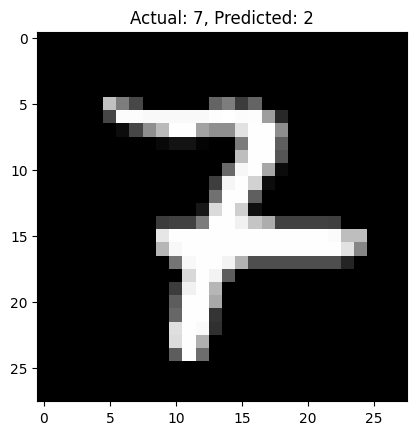

In [7]:
import numpy as np
import matplotlib.pyplot as plt

##############################
# 1. He Initialization
##############################
def initialize_parameters():
    """
    Initialize parameters using He initialization for a 3-hidden-layer network.
    Layers:
      Input -> Hidden 1 (128 neurons)
      Hidden 1 -> Hidden 2 (64 neurons)
      Hidden 2 -> Hidden 3 (32 neurons)
      Hidden 3 -> Output (10 neurons)
    """
    np.random.seed(0)  # For reproducibility

    # He initialization
    W1 = np.random.randn(128, 784) * np.sqrt(2 / 784)
    B1 = np.zeros((128, 1))
    W2 = np.random.randn(64, 128) * np.sqrt(2 / 128)
    B2 = np.zeros((64, 1))
    W3 = np.random.randn(32, 64) * np.sqrt(2 / 64)
    B3 = np.zeros((32, 1))
    W4 = np.random.randn(10, 32) * np.sqrt(2 / 32)
    B4 = np.zeros((10, 1))
    
    return W1, B1, W2, B2, W3, B3, W4, B4

##############################
# 2. Activation Functions
##############################
def ReLU(Z):
    return np.maximum(0, Z)

def softmax_calculator(Z):
    Z_stable = Z - np.max(Z, axis=0, keepdims=True)  # Numerical stability
    exps = np.exp(Z_stable)
    return exps / np.sum(exps, axis=0, keepdims=True)

##############################
# 3. Forward Propagation
##############################
def forward_propagation(W1, B1, W2, B2, W3, B3, W4, B4, X):
    """
    Forward propagation for a 3-hidden-layer network.
    """
    # Layer 1
    Z1 = np.dot(W1, X) + B1
    A1 = ReLU(Z1)
    
    # Layer 2
    Z2 = np.dot(W2, A1) + B2
    A2 = ReLU(Z2)
    
    # Layer 3
    Z3 = np.dot(W3, A2) + B3
    A3 = ReLU(Z3)
    
    # Output Layer
    Z4 = np.dot(W4, A3) + B4
    A4 = softmax_calculator(Z4)
    
    return Z1, A1, Z2, A2, Z3, A3, Z4, A4

##############################
# 4. Backward Propagation
##############################
def one_hot_converter(Y):
    """
    Convert labels to one-hot encoding.
    """
    m = Y.size
    num_classes = Y.max() + 1
    one_hot = np.zeros((num_classes, m))
    one_hot[Y, np.arange(m)] = 1
    return one_hot

def backward_propagation(W1, B1, W2, B2, W3, B3, W4, B4,
                         Z1, A1, Z2, A2, Z3, A3, Z4, A4, X, Y):
    """
    Backward propagation for a 3-hidden-layer network.
    """
    m = X.shape[1]
    one_hot_Y = one_hot_converter(Y)  # Convert labels to one-hot encoding

    # Gradients for output layer
    dZ4 = A4 - one_hot_Y
    dW4 = (1/m) * np.dot(dZ4, A3.T)
    dB4 = (1/m) * np.sum(dZ4, axis=1, keepdims=True)

    # Gradients for hidden layer 3
    dA3 = np.dot(W4.T, dZ4)
    dZ3 = dA3 * (Z3 > 0)  # Derivative of ReLU
    dW3 = (1/m) * np.dot(dZ3, A2.T)
    dB3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

    # Gradients for hidden layer 2
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * (Z2 > 0)  # Derivative of ReLU
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    dB2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # Gradients for hidden layer 1
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0)  # Derivative of ReLU
    dW1 = (1/m) * np.dot(dZ1, X.T)
    dB1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, dB1, dW2, dB2, dW3, dB3, dW4, dB4

##############################
# 5. Update Parameters
##############################
def update_parameters(W1, B1, W2, B2, W3, B3, W4, B4,
                      dW1, dB1, dW2, dB2, dW3, dB3, dW4, dB4, alpha):
    """
    Update weights and biases using gradient descent.
    """
    W1 -= alpha * dW1
    B1 -= alpha * dB1
    W2 -= alpha * dW2
    B2 -= alpha * dB2
    W3 -= alpha * dW3
    B3 -= alpha * dB3
    W4 -= alpha * dW4
    B4 -= alpha * dB4
    return W1, B1, W2, B2, W3, B3, W4, B4

##############################
# 6. Training Function
##############################
def get_predictions(A4):
    return np.argmax(A4, axis=0)

def get_accuracy(predictions, Y):
    return np.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    """
    Perform gradient descent for a 3-hidden-layer network.
    """
    W1, B1, W2, B2, W3, B3, W4, B4 = initialize_parameters()
    for i in range(iterations):
        # Forward propagation
        Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward_propagation(W1, B1, W2, B2, W3, B3, W4, B4, X)
        # Backward propagation
        dW1, dB1, dW2, dB2, dW3, dB3, dW4, dB4 = backward_propagation(
            W1, B1, W2, B2, W3, B3, W4, B4, Z1, A1, Z2, A2, Z3, A3, Z4, A4, X, Y
        )
        # Update parameters
        W1, B1, W2, B2, W3, B3, W4, B4 = update_parameters(
            W1, B1, W2, B2, W3, B3, W4, B4, dW1, dB1, dW2, dB2, dW3, dB3, dW4, dB4, alpha
        )
        
        # Print training accuracy every 20 epochs
        if i % 20 == 0:
            preds = get_predictions(A4)
            acc = get_accuracy(preds, Y)
            print(f"Epoch {i}, Training Accuracy: {acc:.4f}")
    return W1, B1, W2, B2, W3, B3, W4, B4

##############################
# 7. Train and Evaluate
##############################
# Hyperparameters
alpha = 0.01       # Learning rate
iterations = 400   # Number of epochs

print("\nStarting training with 3 hidden layers and 400 epochs...\n")
W1, B1, W2, B2, W3, B3, W4, B4 = gradient_descent(X_train, Y_train, alpha, iterations)

# Evaluate on validation set
_, _, _, _, _, _, _, A4_val = forward_propagation(W1, B1, W2, B2, W3, B3, W4, B4, X_val)
preds_val = get_predictions(A4_val)
val_accuracy = get_accuracy(preds_val, Y_val)
print(f"\nValidation Accuracy = {val_accuracy:.4f}")

##############################
# 8. Inspect a Sample
##############################
val_index = 100
sample_image = X_val[:, val_index].reshape(28, 28)
sample_label = Y_val[val_index]

# Predict on the sample
_, _, _, _, _, _, _, A4_sample = forward_propagation(W1, B1, W2, B2, W3, B3, W4, B4, X_val[:, val_index, None])
predicted_label = get_predictions(A4_sample)[0]

plt.imshow(sample_image, cmap='gray')
plt.title(f"Actual: {sample_label}, Predicted: {predicted_label}")
plt.show()
